In [1]:
# Import Library yang Bersangkutan
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report

In [2]:
# 1. Load Data
df = pd.read_csv('../Datasets/data_banjir_per_jam.csv', parse_dates=['Tanggal'])
print(df.head())

      Desa    Tanggal       Jam  Curah Hujan (mm)  Luas Desa (ha)  \
0  Gonilan 2024-01-01  00:00:00               0.0             232   
1  Gonilan 2024-01-01  01:00:00               0.0             232   
2  Gonilan 2024-01-01  02:00:00               0.0             232   
3  Gonilan 2024-01-01  03:00:00               0.0             232   
4  Gonilan 2024-01-01  04:00:00               0.0             232   

   Debit Air (m³/jam) Aliran Sungai  Debit Maks (m³/jam)  Banjir  
0                 0.0           NaN              53352.0   False  
1                 0.0           NaN              53352.0   False  
2                 0.0           NaN              53352.0   False  
3                 0.0           NaN              53352.0   False  
4                 0.0           NaN              53352.0   False  


In [3]:
# 2. Praproses Data Time Series
df['rolling_rain_3h'] = df['Curah Hujan (mm)'].rolling(window=3).mean()
df['lag_1'] = df['Curah Hujan (mm)'].shift(1)
df.fillna(0, inplace=True)

In [4]:
from sklearn.model_selection import train_test_split

# List unik desa
unique_desas = df['Desa'].unique()

X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

for desa in unique_desas:
    # Filter data per desa
    df_desa = df[df['Desa'] == desa].copy()
    
    # Time-based split untuk desa ini (70% train, 30% test)
    split_idx = int(len(df_desa) * 0.7)
    
    X = df_desa[['rolling_rain_3h', 'Debit Air (m³/jam)', 'Debit Maks (m³/jam)', 'lag_1']]
    y = df_desa['Banjir']
    
    X_train_list.append(X[:split_idx])
    X_test_list.append(X[split_idx:])
    y_train_list.append(y[:split_idx])
    y_test_list.append(y[split_idx:])

# Gabungkan semua kelompok
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

In [13]:
X_test.describe()

,rolling_rain_3h,Debit Air (m³/jam),Debit Maks (m³/jam),lag_1
count,31632.000000,31632.000000,31632.000000,31632.000000
mean,2.477091,4005.982875,87300.000000,2.477159
std,3.566332,7039.018600,27961.041971,4.164998
min,0.000000,0.000000,53352.000000,0.000000
25%,0.000000,0.000000,71280.000000,0.000000
50%,0.000000,0.000000,75240.000000,0.000000
75%,4.550000,5706.375000,122688.000000,3.700000
max,27.560000,74796.800000,133272.000000,34.950000


In [15]:
y_test.value_counts()

Banjir
False    30153
True      1479
Name: count, dtype: int64

In [7]:
# 4. Train Random Forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [8]:
# 5. Evaluasi
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     30153
        True       0.92      0.94      0.93      1479

    accuracy                           0.99     31632
   macro avg       0.96      0.97      0.96     31632
weighted avg       0.99      0.99      0.99     31632



In [9]:
import joblib
joblib.dump(model, 'model_banjir_rf.pkl')

['model_banjir_rf.pkl']

In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[30032   121]
 [   94  1385]]


# Visualisasi Data

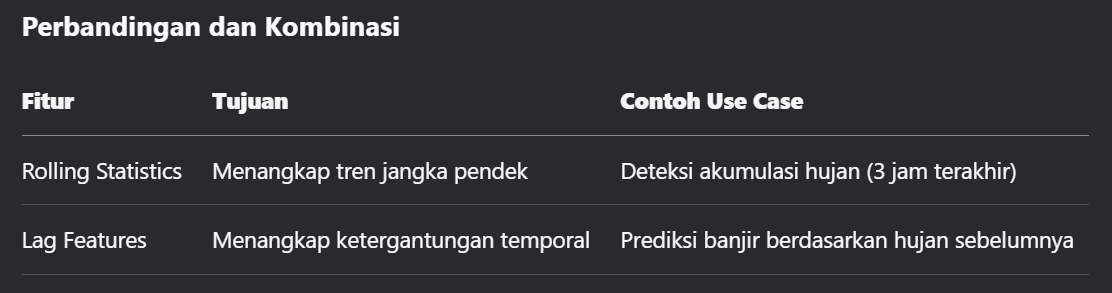

In [11]:
# 1. Hitung rolling statistics
windows = [3, 6, 12]  # Jam
for window in windows:
    df[f'rolling_mean_{window}h'] = df.groupby('Desa')['Curah Hujan (mm)'].transform(
        lambda x: x.rolling(window=window).mean()
    )
    df[f'rolling_max_{window}h'] = df.groupby('Desa')['Curah Hujan (mm)'].transform(
        lambda x: x.rolling(window=window).max()
    )

# 2. Buat lag features
lags = [1, 3, 6]  # Jam
for lag in lags:
    df[f'lag_{lag}'] = df.groupby('Desa')['Curah Hujan (mm)'].shift(lag)

# 3. Fitur interaksi
df['debit_vs_kapasitas'] = df['Debit Air (m³/jam)'] / df['Debit Maks (m³/jam)']
df['hujan_ekstrem'] = (df['rolling_max_6h'] > 15).astype(int)  # Binary: 1 jika hujan >15mm dalam 6 jam

# Isi missing values
df.fillna(0, inplace=True)

# Contoh fitur akhir
fitur = [
    'rolling_mean_3h', 'rolling_max_6h', 
    'lag_1', 'lag_3',
    'debit_vs_kapasitas', 'hujan_ekstrem'
]
X = df[fitur]
y = df['Banjir']

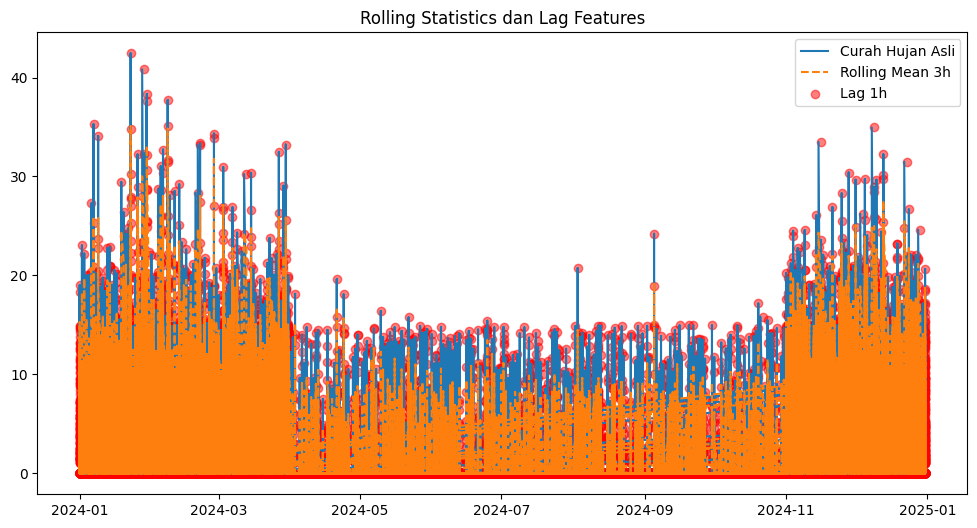

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Curah Hujan (mm)'], label='Curah Hujan Asli')
plt.plot(df['Tanggal'], df['rolling_mean_3h'], label='Rolling Mean 3h', linestyle='--')
plt.scatter(df['Tanggal'], df['lag_1'], label='Lag 1h', color='red', alpha=0.5)
plt.legend()
plt.title('Rolling Statistics dan Lag Features')
plt.show()